In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
import tensorflow as tf
tf.enable_eager_execution()

In [4]:
from agnfinder.tf_sampling import deep_emulator

In [17]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [18]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']
save_dir = 'results/emulated_sampling/real'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert galaxy_locs

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    f = h5py.File(galaxy_loc, mode='r')
    galaxies.append({
        'samples': np.squeeze(f['samples'][...]),
        'name': galaxy_loc.split('_')[-2],
        'true_observations': np.squeeze(f['true_observations'][...]),
    })

n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [19]:
galaxies[0]['true_observations'].shape

(12,)

### Load parquet for labels

In [20]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
labels = pd.read_parquet('data/uk_ir_selection.parquet')

In [21]:
labels['most_likely_rf_class'] = labels[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)
labels['most_likely_rf_class'].value_counts()

passive        9
starforming    7
qso            7
starburst      6
agn            5
Name: most_likely_rf_class, dtype: int64

In [22]:
label_dict = dict(zip(labels.index, labels['most_likely_rf_class'].values))
# label_dict

In [23]:
for galaxy in galaxies:
    galaxy['rf_class'] = label_dict[int(galaxy['name'])]

In [24]:
galaxy_locs

['results/emulated_sampling/real/galaxy_4_performance.h5',
 'results/emulated_sampling/real/galaxy_16_performance.h5',
 'results/emulated_sampling/real/galaxy_22_performance.h5',
 'results/emulated_sampling/real/galaxy_1_performance.h5',
 'results/emulated_sampling/real/galaxy_31_performance.h5',
 'results/emulated_sampling/real/galaxy_8_performance.h5',
 'results/emulated_sampling/real/galaxy_27_performance.h5',
 'results/emulated_sampling/real/galaxy_11_performance.h5',
 'results/emulated_sampling/real/galaxy_28_performance.h5',
 'results/emulated_sampling/real/galaxy_32_performance.h5',
 'results/emulated_sampling/real/galaxy_15_performance.h5',
 'results/emulated_sampling/real/galaxy_30_performance.h5',
 'results/emulated_sampling/real/galaxy_24_performance.h5',
 'results/emulated_sampling/real/galaxy_29_performance.h5',
 'results/emulated_sampling/real/galaxy_10_performance.h5',
 'results/emulated_sampling/real/galaxy_18_performance.h5',
 'results/emulated_sampling/real/galaxy_7_p

### How do we do at reproducing observations?

In [25]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

In [33]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])



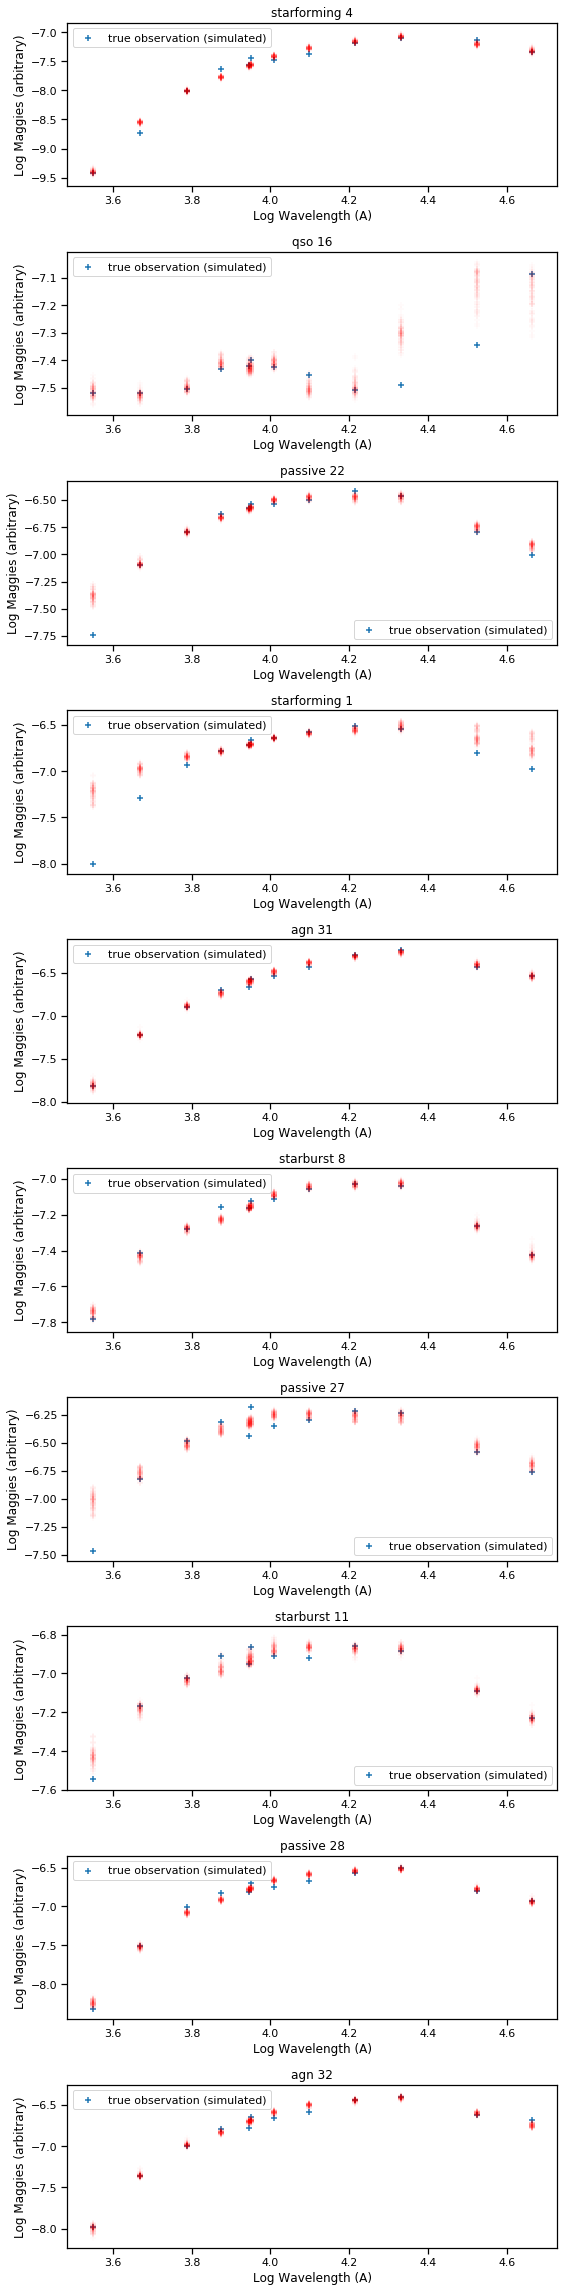

In [166]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

for n, galaxy in enumerate(galaxies[:n_galaxies]):
    ax = axes[n]
    true_photometry = galaxy['true_observations']
    sample_photometry = deep_emulator.denormalise_photometry(emulator(galaxy['samples'])).numpy()
    np.random.shuffle(sample_photometry)

    ax.scatter(np.log10(wavelengths), np.log10(true_photometry), label='true observation (simulated)', marker='+')
    for trace in sample_photometry[:100]:
        ax.scatter(np.log10(wavelengths), np.log10(trace), color='r', marker='+', alpha=0.02)
    ax.legend()
    ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Log Maggies (arbitrary)')
    ax.set_xlabel('Log Wavelength (A)')
    
plt.tight_layout()

In [83]:
galaxy['rf_class']

'qso'

In [118]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [119]:
raw_df.head()

,index,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,rf_class
0,0,0.617541,0.694133,0.199702,0.153586,0.255291,0.609870,0.404166,starforming
1,1,0.610669,0.669032,0.213490,0.162051,0.265433,0.607954,0.400020,starforming
2,2,0.618840,0.681978,0.215063,0.157913,0.250672,0.612664,0.388587,starforming
3,3,0.629119,0.706976,0.224830,0.181965,0.235048,0.594102,0.400812,starforming
4,4,0.629119,0.706976,0.224830,0.181965,0.235048,0.594102,0.400812,starforming


In [120]:
len(raw_df)

68000

In [121]:
df = raw_df

In [122]:
df['rf_class']

0        starforming
1        starforming
2        starforming
3        starforming
4        starforming
            ...     
67995            qso
67996            qso
67997            qso
67998            qso
67999            qso
Name: rf_class, Length: 68000, dtype: object

In [123]:
df[params].median()

mass                 0.651287
dust2                0.054245
tage                 0.233402
tau                  0.210595
agn_disk_scaling     0.370939
agn_eb_v             0.600313
agn_torus_scaling    0.235849
dtype: float32

In [124]:
(df[params] > 1e-3).shape

(68000, 7)

In [125]:
df = df[np.all(df[params] > 1e-3, axis=1)]
df = df[np.all(df[params] < .999, axis=1)]

In [126]:
df[params].min()

mass                 0.061319
dust2                0.001002
tage                 0.003831
tau                  0.001002
agn_disk_scaling     0.001003
agn_eb_v             0.001083
agn_torus_scaling    0.001007
dtype: float32

In [127]:
df[params].max()

mass                 0.998266
dust2                0.998546
tage                 0.998970
tau                  0.998939
agn_disk_scaling     0.856788
agn_eb_v             0.998991
agn_torus_scaling    0.785933
dtype: float32

In [128]:
# free_params = ['mass', 'dust2', 'tage', 'agn_eb_v', 'agn_torus_mass']
# log_params = ['mass', 'agn_mass', 'tau']

In [129]:
df['rf_class']

0        starforming
1        starforming
2        starforming
3        starforming
4        starforming
            ...     
67995            qso
67996            qso
67997            qso
67998            qso
67999            qso
Name: rf_class, Length: 63617, dtype: object

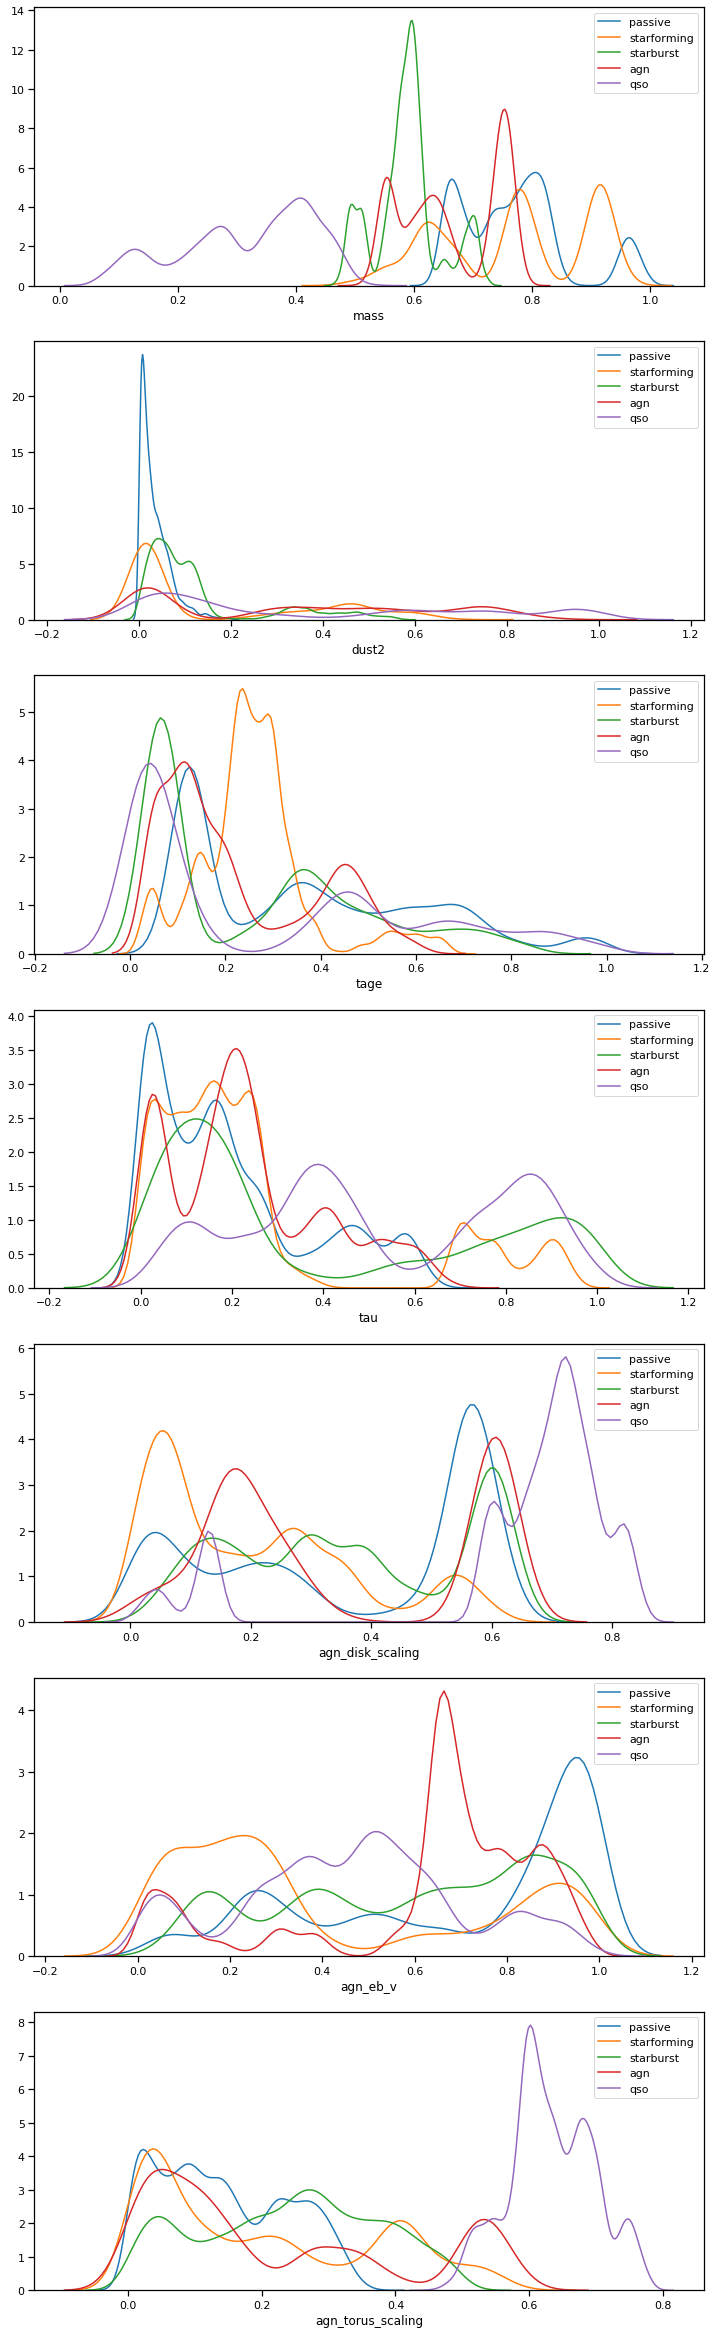

In [136]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in rf_classes:
        values = df[df['rf_class'] == galaxy_class][feature]
#         if feature in log_params:
#             values = np.log10(values)
#         print(values.shape)
        if len(values) > 0:
            sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

In [ ]:
# df = df[df['rf_class'] != 'agn']

In [140]:
from agnfinder import simulation_utils
from collections import OrderedDict

# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())


In [145]:
for galaxy in galaxies:
    galaxy['denormalised_samples'] = simulation_utils.denormalise_hypercube(galaxy['samples'], free_params)

In [146]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['denormalised_samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [147]:
df = raw_df

In [150]:
df[params].min()

mass                 1.759043e+08
dust2                4.026943e-06
tage                 5.386830e-02
tau                  1.000003e-01
agn_disk_scaling     1.000131e-07
agn_eb_v             9.080413e-05
agn_torus_scaling    1.000069e-07
dtype: float32

In [159]:
log_params = ['mass', 'tau', 'agn_disk_scaling', 'agn_torus_scaling']

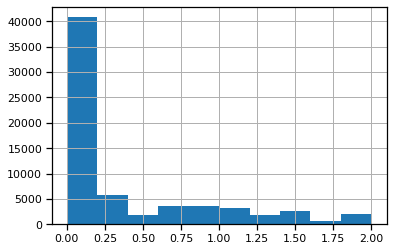

In [160]:
df['dust2'].hist()

(18000,)
(14000,)
Failed mass starforming
(12000,)
(10000,)
(14000,)
(0,)
(18000,)
(14000,)
Failed dust2 starforming
(12000,)
(10000,)
(14000,)
(0,)
(18000,)
(14000,)
Failed tage starforming
(12000,)
(10000,)
(14000,)
(0,)
(18000,)
(14000,)
Failed tau starforming
(12000,)
(10000,)
(14000,)
(0,)
(18000,)
(14000,)
Failed agn_disk_scaling starforming
(12000,)
(10000,)
(14000,)
(0,)
(18000,)
(14000,)
Failed agn_eb_v starforming
(12000,)
(10000,)
(14000,)
(0,)
(18000,)
(14000,)
Failed agn_torus_scaling starforming
(12000,)
(10000,)
(14000,)
(0,)


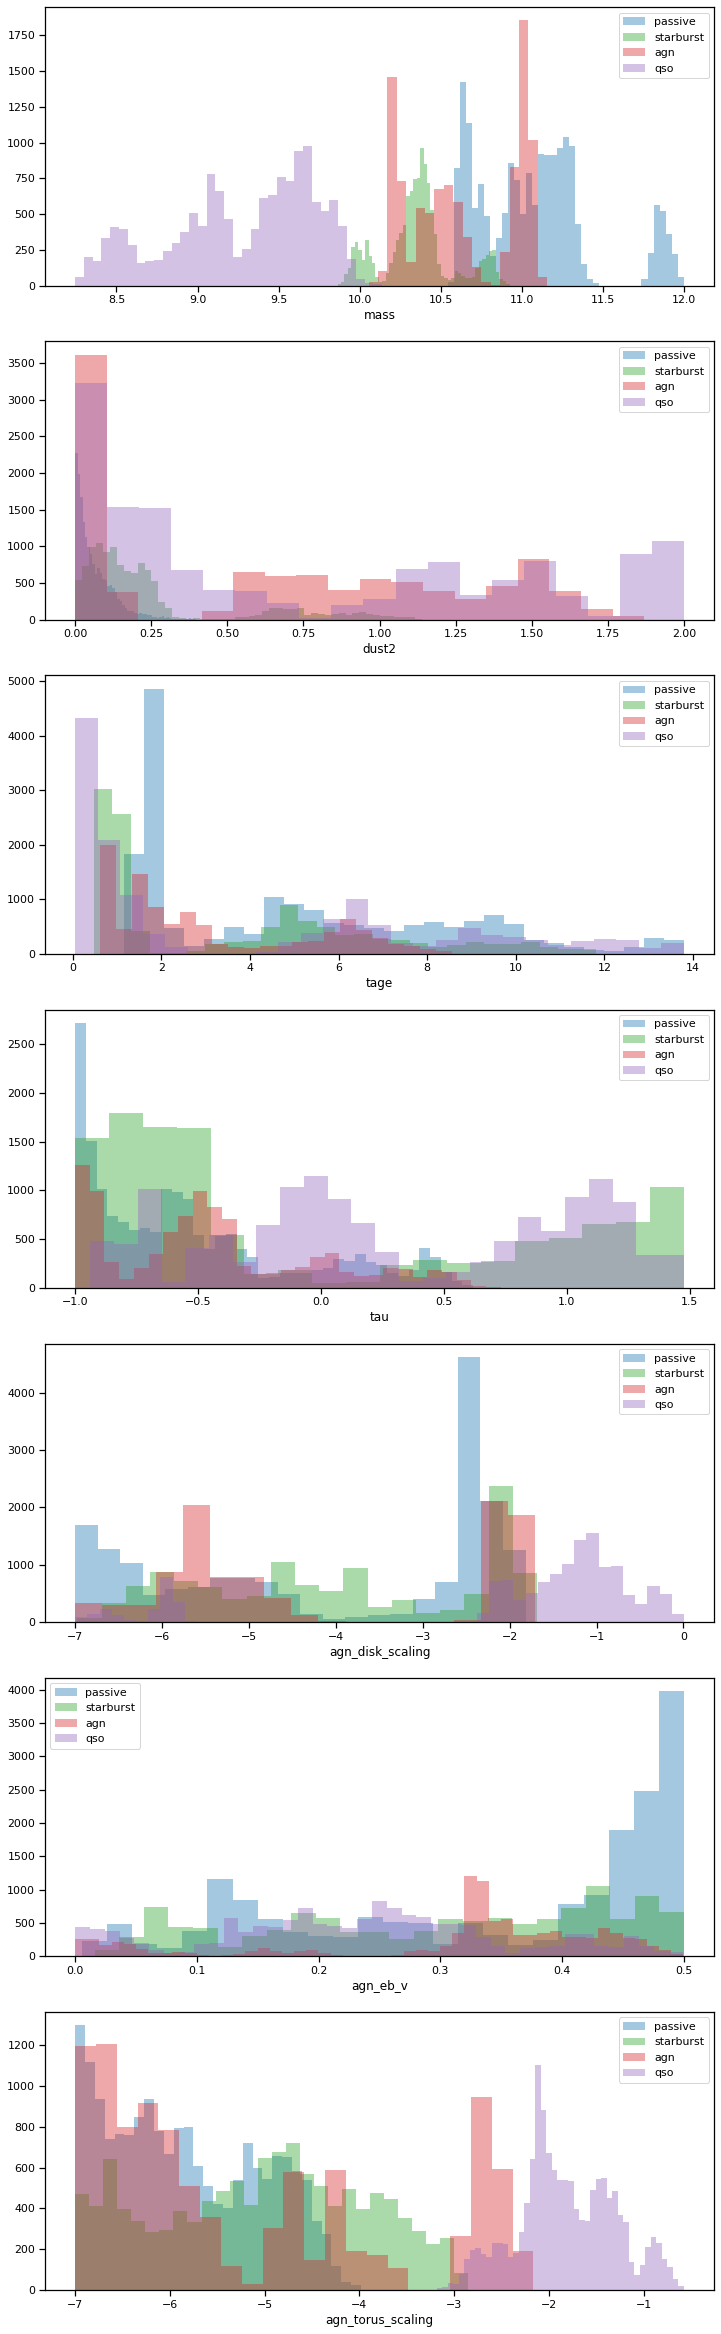

In [161]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in rf_classes:
        values = df[df['rf_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        print(values.shape)
        if len(values) > 0:
            try:
                sns.distplot(values, label=galaxy_class, kde=False, ax=ax)
            except ValueError:
                print('Failed {} {}'.format(feature, galaxy_class))
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')